# Oxygen Forecasting Model (Anomaly-Aware, Global Forecaster with Train/Validation/Test Split)

This notebook builds a **generic forecasting model** for minute-level oxygen readings,
using the **scored, processed dataset** from the anomaly detection pipeline.

According to the assignment requirements:

- We must build a **generic** forecaster that can work across multiple tags/customers
  without relying on tag semantics.
- The model should forecast **minute-level oxygen saturation**, ideally for the next
  1 week, while **handling anomalies**.
- The modelling process should use a **train/validation/test** split:
  - Train: used for fitting model parameters.
  - Validation: used only for hyperparameter tuning / model selection.
  - Test: used only once for final, unbiased evaluation.

In this notebook we:

1. **Load** the scored, processed dataset (`oxygen_processed.csv`).
2. **Clean** the data by:
   - Removing rows with null timestamps or null oxygen values.
   - Removing highly anomalous records based on the **anomaly severity** score.
3. **Engineer time-series features** (lags + calendar features).
4. **Split** the data into train / validation / test by time.
5. **Train an anomaly-aware global forecasting model** using only the training set.
6. **Use the validation set** for simple hyperparameter tuning / model selection.
7. **Evaluate** the final model on the held-out test set.
8. Provide flexible **visualisation utilities** to:
   - Plot all splits together (train + validation + test),
   - Plot only the training / validation / test ranges,
   - Zoom into custom time windows for detailed inspection.
9. Illustrate a **1-week-ahead forecast** for a single sensor and explain the
   straight-line behaviour.


In [1]:
# %% Imports & plotting config

import numpy as np
import pandas as pd
import os
from pathlib import Path

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12, 5)
plt.rcParams["axes.grid"] = True

from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [2]:
# %% Train/validation/test split parameters (in days)

VALID_DAYS = 7   # length of validation set
TEST_DAYS  = 7   # length of test set

print(f"Validation window: {VALID_DAYS} days")
print(f"Test window:       {TEST_DAYS} days")


Validation window: 7 days
Test window:       7 days


In [3]:
DATA_DIR = os.path.abspath(os.path.join(os.getcwd(), "../" , "data"))
DATA_RAW_DIR = Path(os.path.join(DATA_DIR, "raw"))
DATA_PROCESSED_DIR = Path(os.path.join(DATA_DIR, "processed"))
# Path to the dataset (adjust this if needed)
processed_path = Path(os.path.join(DATA_PROCESSED_DIR, "oxygen_processed.csv"))
save_path = Path(os.path.join(DATA_PROCESSED_DIR, "oxygen_processed_saved.csv"))

In [4]:
# %% Load the scored, processed dataset

# Path to the scored, processed dataset from the previous notebook
data_path = processed_path  # adjust if needed

df = pd.read_csv(data_path, index_col=0)

# Try to parse 'time' if present
if "time" in df.columns:
    df["time"] = pd.to_datetime(df["time"], errors="coerce")

print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
df.head()


Shape: (1612639, 23)
Columns: ['time', 'sensor_id', 'oxygen', 'hour', 'dayofweek', 'synthetic_label', 'roll_mean', 'roll_std', 'z_global', 'score_point', 'roll_mean_abs_z', 'score_collective', 'ctx_mean_hour', 'ctx_std_hour', 'z_context', 'score_context', 'roll_std_long', 'score_stuck', 'score_spike', 'roll_std_noise', 'score_noise', 'score_sensor_fault', 'severity']


,time,sensor_id,oxygen,hour,dayofweek,synthetic_label,roll_mean,roll_std,z_global,score_point,...,ctx_std_hour,z_context,score_context,roll_std_long,score_stuck,score_spike,roll_std_noise,score_noise,score_sensor_fault,severity
0,2025-04-01 17:43:00,System_10|EquipmentUnit_05|nan,91.639549,17,1,normal,NaN,NaN,NaN,NaN,...,5.891127,0.679695,0.0,NaN,NaN,0.0,NaN,NaN,0.0,0.0
1,2025-04-01 17:44:00,System_10|EquipmentUnit_05|nan,91.443474,17,1,normal,NaN,NaN,NaN,NaN,...,5.891127,0.646412,0.0,NaN,NaN,0.0,NaN,NaN,0.0,0.0
2,2025-04-01 17:45:00,System_10|EquipmentUnit_05|nan,91.784111,17,1,normal,NaN,NaN,NaN,NaN,...,5.891127,0.704234,0.0,NaN,NaN,0.0,NaN,NaN,0.0,0.0
3,2025-04-01 17:46:00,System_10|EquipmentUnit_05|nan,92.180275,17,1,normal,NaN,NaN,NaN,NaN,...,5.891127,0.771482,0.0,NaN,NaN,0.0,NaN,NaN,0.0,0.0
4,2025-04-01 17:47:00,System_10|EquipmentUnit_05|nan,92.131180,17,1,normal,NaN,NaN,NaN,NaN,...,5.891127,0.763148,0.0,NaN,NaN,0.0,NaN,NaN,0.0,0.0


In [5]:
# %% Identify oxygen column and required fields

# Identify the oxygen column: either 'oxygen' or 'Oxygen[%sat]'
if "oxygen" in df.columns:
    value_col = "oxygen"
elif "Oxygen[%sat]" in df.columns:
    value_col = "Oxygen[%sat]"
else:
    raise ValueError(
        "Expected either 'oxygen' or 'Oxygen[%sat]' in columns. Found: "
        + ", ".join(df.columns)
    )

# Check severity column
if "severity" not in df.columns:
    raise ValueError(
        "Expected 'severity' column with anomaly severity scores in the processed dataset."
    )

# Ensure sensor_id exists (for grouping); if not, treat entire dataset as one series
if "sensor_id" not in df.columns:
    print("Warning: 'sensor_id' not found. Treating all data as a single global series.")
    df["sensor_id"] = "global"

df[[ "time", "sensor_id", value_col, "severity" ]].head()


,time,sensor_id,oxygen,severity
0,2025-04-01 17:43:00,System_10|EquipmentUnit_05|nan,91.639549,0.0
1,2025-04-01 17:44:00,System_10|EquipmentUnit_05|nan,91.443474,0.0
2,2025-04-01 17:45:00,System_10|EquipmentUnit_05|nan,91.784111,0.0
3,2025-04-01 17:46:00,System_10|EquipmentUnit_05|nan,92.180275,0.0
4,2025-04-01 17:47:00,System_10|EquipmentUnit_05|nan,92.131180,0.0


In [6]:
# %% Clean data: drop nulls and filter out highly anomalous points

# 1) Drop rows with null timestamps or null oxygen values
before_null = len(df)
df_clean = df[df["time"].notna() & df[value_col].notna()].copy()
after_null = len(df_clean)
print(f"Removed {before_null - after_null} rows due to null time or null {value_col}.")

# 2) Remove highly anomalous records based on severity score
#    Strategy: drop the top 1% most severe points (severity >= 99th percentile).
sev_q99 = df_clean["severity"].quantile(0.99)
print("99th percentile of severity:", sev_q99)

df_clean = df_clean[df_clean["severity"] < sev_q99].copy()
after_anom = len(df_clean)
print(f"Removed {after_null - after_anom} rows as 'highly anomalous' (severity >= q99).")

df_clean = df_clean.sort_values(["sensor_id", "time"]).reset_index(drop=True)
print("Final cleaned shape:", df_clean.shape)


Removed 0 rows due to null time or null oxygen.
99th percentile of severity: 0.9708921829569216
Removed 16127 rows as 'highly anomalous' (severity >= q99).
Final cleaned shape: (1596512, 23)


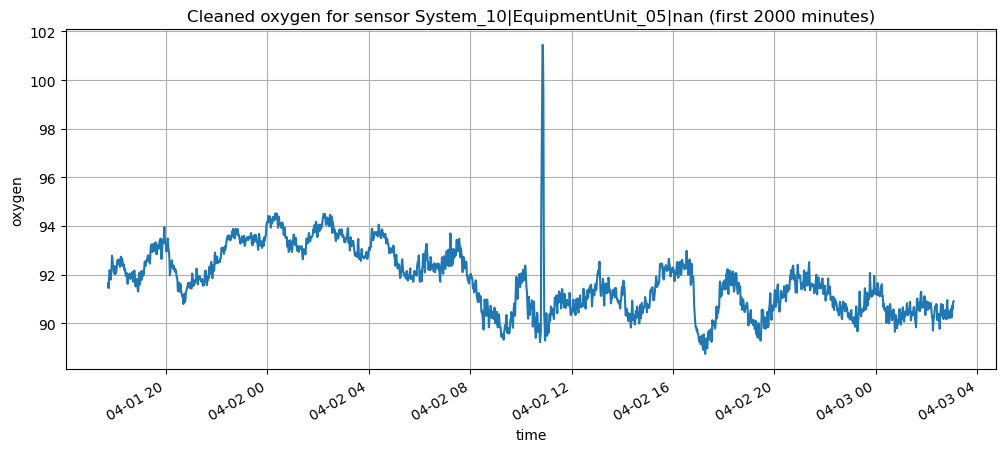

In [7]:
# %% Basic visual check for one sensor (optional)

sample_sensor = df_clean["sensor_id"].iloc[0]
mask = df_clean["sensor_id"] == sample_sensor

df_sample = df_clean.loc[mask].set_index("time").sort_index().iloc[:2000]

df_sample[value_col].plot()
plt.title(f"Cleaned oxygen for sensor {sample_sensor} (first 2000 minutes)")
plt.xlabel("time")
plt.ylabel(value_col)
plt.show()


In [8]:
# %% Feature engineering: lags + calendar features

df_feat = df_clean.copy()

# Time-based features
df_feat["minute_of_day"] = df_feat["time"].dt.hour * 60 + df_feat["time"].dt.minute
df_feat["dayofweek"] = df_feat["time"].dt.dayofweek

# Cyclical encoding for time-of-day (period = 1440 minutes)
df_feat["sin_time"] = np.sin(2 * np.pi * df_feat["minute_of_day"] / 1440)
df_feat["cos_time"] = np.cos(2 * np.pi * df_feat["minute_of_day"] / 1440)

# Cyclical encoding for day-of-week (period = 7)
df_feat["sin_dow"] = np.sin(2 * np.pi * df_feat["dayofweek"] / 7)
df_feat["cos_dow"] = np.cos(2 * np.pi * df_feat["dayofweek"] / 7)

# Lag features per sensor: 1, 5, 60 minutes
lag_steps = [1, 5, 60]
for lag in lag_steps:
    df_feat[f"lag_{lag}"] = (
        df_feat.groupby("sensor_id")[value_col]
        .shift(lag)
    )

# Rolling mean over 60 minutes as a smoothed baseline
df_feat["roll_mean_60"] = (
    df_feat.groupby("sensor_id")[value_col]
    .rolling(window=60, min_periods=30)
    .mean()
    .reset_index(level=0, drop=True)
)

# Drop rows where any feature is NaN (due to initial lags/rolls)
feature_cols = [
    f"lag_{lag}" for lag in lag_steps
] + [
    "roll_mean_60",
    "sin_time", "cos_time",
    "sin_dow", "cos_dow",
]

df_model = df_feat.dropna(subset=feature_cols + [value_col]).copy()
print("Shape after feature engineering & dropping NaNs:", df_model.shape)
df_model[[ "time", "sensor_id", value_col ] + feature_cols].head()


Shape after feature engineering & dropping NaNs: (1596212, 32)


,time,sensor_id,oxygen,lag_1,lag_5,lag_60,roll_mean_60,sin_time,cos_time,sin_dow,cos_dow
60,2025-04-01 18:43:00,System_10|EquipmentUnit_05|nan,91.887169,91.709824,91.887360,91.639549,92.177401,-0.982450,0.186524,0.781831,0.62349
61,2025-04-01 18:44:00,System_10|EquipmentUnit_05|nan,92.063385,91.887169,91.888031,91.443474,92.187733,-0.981627,0.190809,0.781831,0.62349
62,2025-04-01 18:45:00,System_10|EquipmentUnit_05|nan,92.172234,92.063385,92.106384,91.784111,92.194201,-0.980785,0.195090,0.781831,0.62349
63,2025-04-01 18:46:00,System_10|EquipmentUnit_05|nan,91.985451,92.172234,92.080818,92.180275,92.190954,-0.979925,0.199368,0.781831,0.62349
64,2025-04-01 18:47:00,System_10|EquipmentUnit_05|nan,91.686249,91.985451,91.709824,92.131180,92.183539,-0.979045,0.203642,0.781831,0.62349


In [9]:
df_model.to_csv(save_path)

In [10]:
# %% Train / validation / test split (time-based)

max_time = df_model["time"].max()

test_start = max_time - pd.Timedelta(days=TEST_DAYS)
valid_start = test_start - pd.Timedelta(days=VALID_DAYS)

print("Max time in dataset:     ", max_time)
print("Validation window start: ", valid_start)
print("Test window start:       ", test_start)

train_mask = df_model["time"] < valid_start
valid_mask = (df_model["time"] >= valid_start) & (df_model["time"] < test_start)
test_mask  = df_model["time"] >= test_start

train = df_model.loc[train_mask].copy()
valid = df_model.loc[valid_mask].copy()
test  = df_model.loc[test_mask].copy()

print("Train shape:", train.shape)
print("Valid shape:", valid.shape)
print("Test shape: ", test.shape)


Max time in dataset:      2025-11-14 09:31:00
Validation window start:  2025-10-31 09:31:00
Test window start:        2025-11-07 09:31:00
Train shape: (1495817, 32)
Valid shape: (50098, 32)
Test shape:  (50297, 32)


In [11]:
# %% Prepare feature matrices and targets

X_train = train[feature_cols]
y_train = train[value_col]

X_valid = valid[feature_cols]
y_valid = valid[value_col]

X_test = test[feature_cols]
y_test = test[value_col]

print("X_train:", X_train.shape)
print("X_valid:", X_valid.shape)
print("X_test: ", X_test.shape)


X_train: (1495817, 8)
X_valid: (50098, 8)
X_test:  (50297, 8)


In [12]:
# %% Hyperparameter tuning on validation set (no test leakage)

param_grid = {
    "learning_rate": [0.03, 0.05, 0.1],
    "max_depth": [None, 8],
    "max_iter": [200],
}

best_mae = np.inf
best_params = None
best_model = None

for lr in param_grid["learning_rate"]:
    for depth in param_grid["max_depth"]:
        model = HistGradientBoostingRegressor(
            learning_rate=lr,
            max_depth=depth,
            max_iter=param_grid["max_iter"][0],
            random_state=42,
        )
        model.fit(X_train, y_train)
        y_val_pred = model.predict(X_valid)
        mae_val = mean_absolute_error(y_valid, y_val_pred)

        print(f"Params lr={lr}, max_depth={depth} -> val MAE = {mae_val:.3f}")

        if mae_val < best_mae:
            best_mae = mae_val
            best_params = {"learning_rate": lr, "max_depth": depth}
            best_model = model

print("\nBest params based on validation MAE:", best_params)
print("Best validation MAE:", best_mae)


Params lr=0.03, max_depth=None -> val MAE = 0.275
Params lr=0.03, max_depth=8 -> val MAE = 0.275
Params lr=0.05, max_depth=None -> val MAE = 0.274
Params lr=0.05, max_depth=8 -> val MAE = 0.274
Params lr=0.1, max_depth=None -> val MAE = 0.274
Params lr=0.1, max_depth=8 -> val MAE = 0.273

Best params based on validation MAE: {'learning_rate': 0.1, 'max_depth': 8}
Best validation MAE: 0.273340167601997


In [13]:
# %% Final model (trained ONLY on train set, chosen via validation)

forecaster = best_model  # already fitted on X_train, y_train

# Evaluate on train, validation, and test
y_pred_train = forecaster.predict(X_train)
y_pred_valid = forecaster.predict(X_valid)
y_pred_test  = forecaster.predict(X_test)

# Compute metrics
def compute_mae_rmse(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    return mae, rmse

mae_tr, rmse_tr = compute_mae_rmse(y_train, y_pred_train)
mae_va, rmse_va = compute_mae_rmse(y_valid, y_pred_valid)
mae_te, rmse_te = compute_mae_rmse(y_test,  y_pred_test)

print(f"Train   MAE: {mae_tr:.3f}, RMSE: {rmse_tr:.3f}")
print(f"Valid   MAE: {mae_va:.3f}, RMSE: {rmse_va:.3f}")
print(f"Test    MAE: {mae_te:.3f}, RMSE: {rmse_te:.3f}")


Train   MAE: 0.431, RMSE: 0.773
Valid   MAE: 0.273, RMSE: 0.506
Test    MAE: 0.239, RMSE: 0.405


In [34]:
# %% Flexible plotting utility for train / valid / test splits with zooming
# Predicted values are shown as circles instead of plain lines.

def plot_sensor_forecast(
    sensor_id=None,
    view="all",
    start_time=None,
    end_time=None,
    window_days=None,
):
    """Plot actual vs predicted oxygen for a single sensor.

    Parameters
    ----------
    sensor_id : str or None
        Which sensor_id to plot. If None, uses the first sensor in df_model.
    view : str
        Which split(s) to show:
        - "all": train + valid + test (default)
        - "train": only training range
        - "valid": only validation range
        - "test": only test range
    start_time : datetime-like or None
        Optional absolute start time for zooming.
    end_time : datetime-like or None
        Optional absolute end time for zooming.
    window_days : float or None
        If start_time and end_time are both None and window_days is provided,
        we zoom into the last `window_days` of the selected view.
    """
    global valid_start, test_start  # defined in the split cell

    if sensor_id is None:
        sensor_id = df_model["sensor_id"].iloc[0]

    print(f"Plotting for sensor: {sensor_id}, view='{view}'")

    df_plot = df_model[df_model["sensor_id"] == sensor_id].copy()
    df_plot = df_plot.sort_values("time").reset_index(drop=True)

    # Assign split labels based on time
    df_plot["split"] = np.where(
        df_plot["time"] < valid_start, "train",
        np.where(df_plot["time"] < test_start, "valid", "test")
    )

    # Compute predictions for ALL rows of this sensor
    X_plot = df_plot[feature_cols]
    df_plot["y_pred"] = forecaster.predict(X_plot)

    # Base view mask
    if view == "all":
        mask_view = np.ones(len(df_plot), dtype=bool)
    elif view in {"train", "valid", "test"}:
        mask_view = df_plot["split"] == view
    else:
        raise ValueError("view must be one of: 'all', 'train', 'valid', 'test'")

    # Optional zooming via absolute times
    if start_time is not None or end_time is not None:
        if start_time is not None:
            start_time = pd.to_datetime(start_time)
            mask_view &= df_plot["time"] >= start_time
        if end_time is not None:
            end_time = pd.to_datetime(end_time)
            mask_view &= df_plot["time"] <= end_time
    elif window_days is not None:
        # Zoom into the last `window_days` of the selected view
        times_in_view = df_plot.loc[mask_view, "time"]
        if len(times_in_view) == 0:
            print("No data in selected view to zoom into.")
        else:
            end_time = times_in_view.max()
            start_time = end_time - pd.Timedelta(days=window_days)
            mask_view &= (df_plot["time"] >= start_time) & (df_plot["time"] <= end_time)

    df_plot_view = df_plot[mask_view].copy()

    colors = {
        "train": "tab:blue",
        "valid": "tab:orange",
        "test":  "tab:green",
    }

    fig, ax = plt.subplots(figsize=(12, 5))

    # Plot split segments within the selected view mask
    for split_name, color in colors.items():
        if view != "all" and split_name != view:
            continue

        mask_split = (df_plot_view["split"] == split_name)
        if not mask_split.any():
            continue

        # Actuals as lines
        ax.plot(
            df_plot_view.loc[mask_split, "time"],
            df_plot_view.loc[mask_split, value_col],
            color=color,
            linestyle="-",
            label=f"{split_name} actual"
        )

        # Predictions as circles (no connecting line)
        ax.plot(
            df_plot_view.loc[mask_split, "time"],
            df_plot_view.loc[mask_split, "y_pred"],
            color=color,
            linestyle="None",
            marker=",",
            markersize=1,
            alpha=0.8,
            label=f"{split_name} predicted"
        )

    ax.set_title(f"Actual vs predicted oxygen for sensor {sensor_id}\nView: {view}")
    ax.set_xlabel("time")
    ax.set_ylabel(value_col)
    ax.legend(loc="best")
    plt.tight_layout()
    plt.show()

In [35]:
df_model["sensor_id"].unique()

array(['System_10|EquipmentUnit_05|nan', 'System_10|EquipmentUnit_06|nan',
       'System_10|EquipmentUnit_10|SubUnit_07',
       'System_10|EquipmentUnit_10|SubUnit_08',
       'System_10|EquipmentUnit_11|nan'], dtype=object)

Plotting for sensor: System_10|EquipmentUnit_05|nan, view='all'


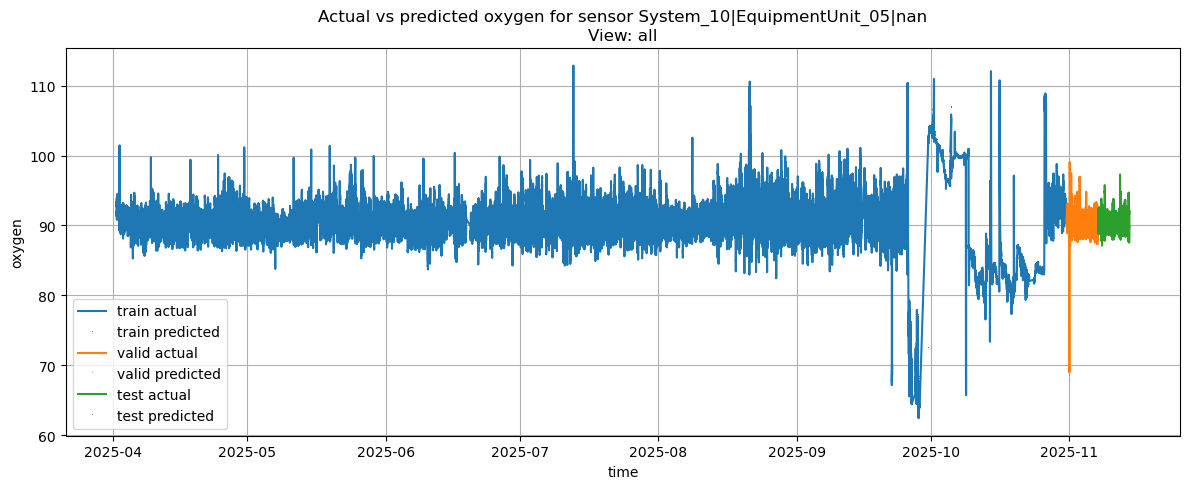

Plotting for sensor: System_10|EquipmentUnit_05|nan, view='train'


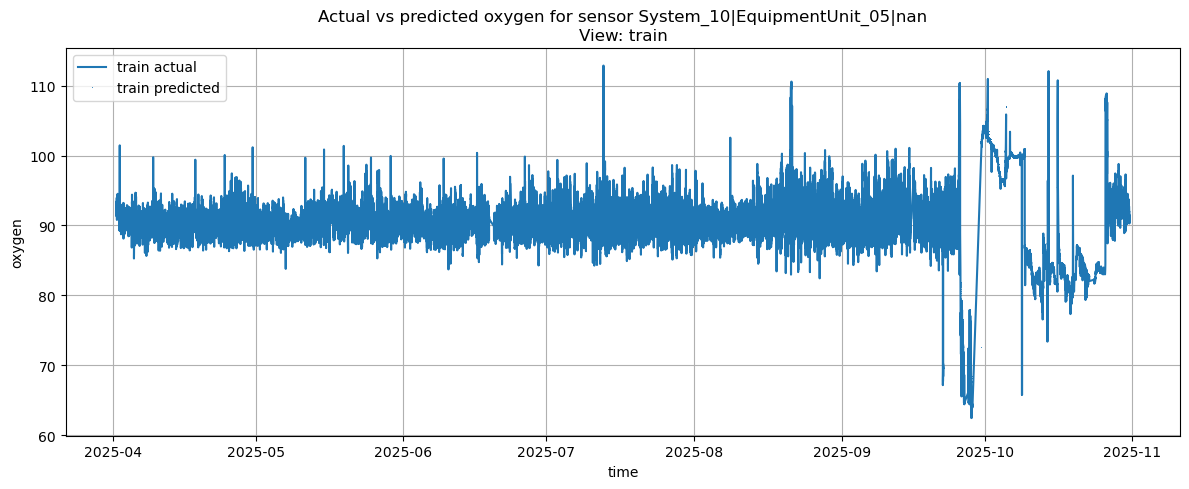

Plotting for sensor: System_10|EquipmentUnit_05|nan, view='valid'


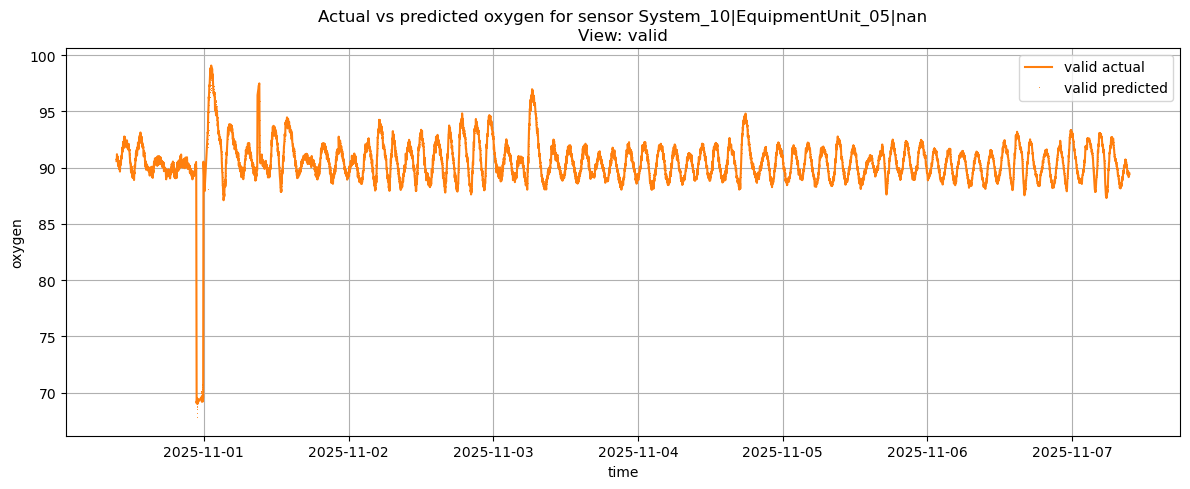

Plotting for sensor: System_10|EquipmentUnit_05|nan, view='test'


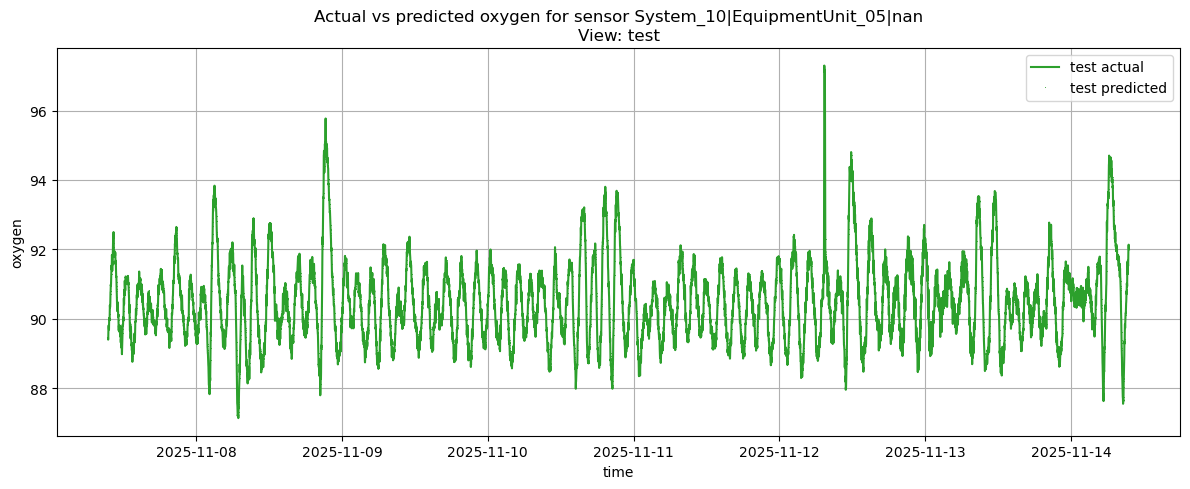

Plotting for sensor: System_10|EquipmentUnit_05|nan, view='valid'


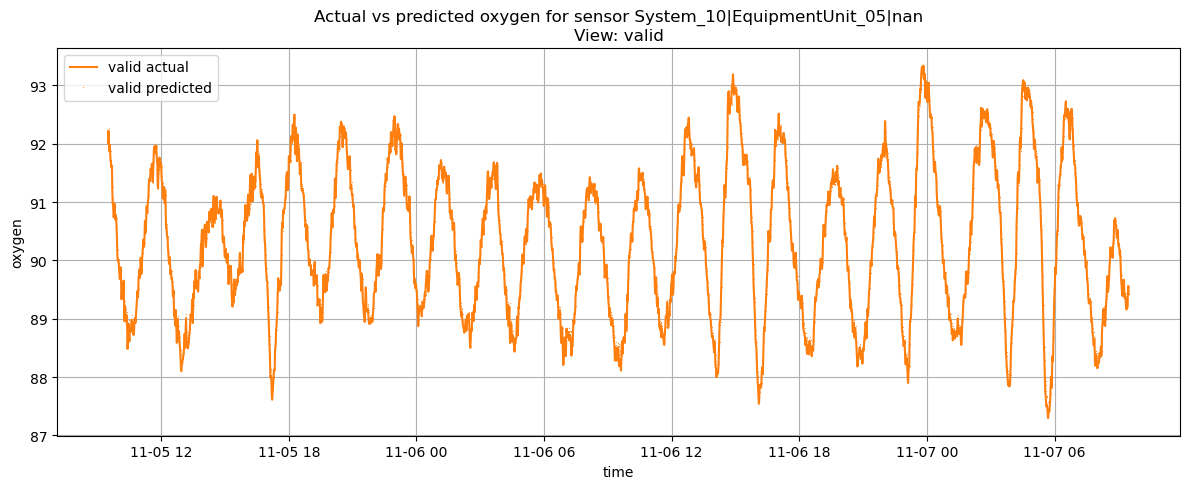

Plotting for sensor: System_10|EquipmentUnit_05|nan, view='valid'


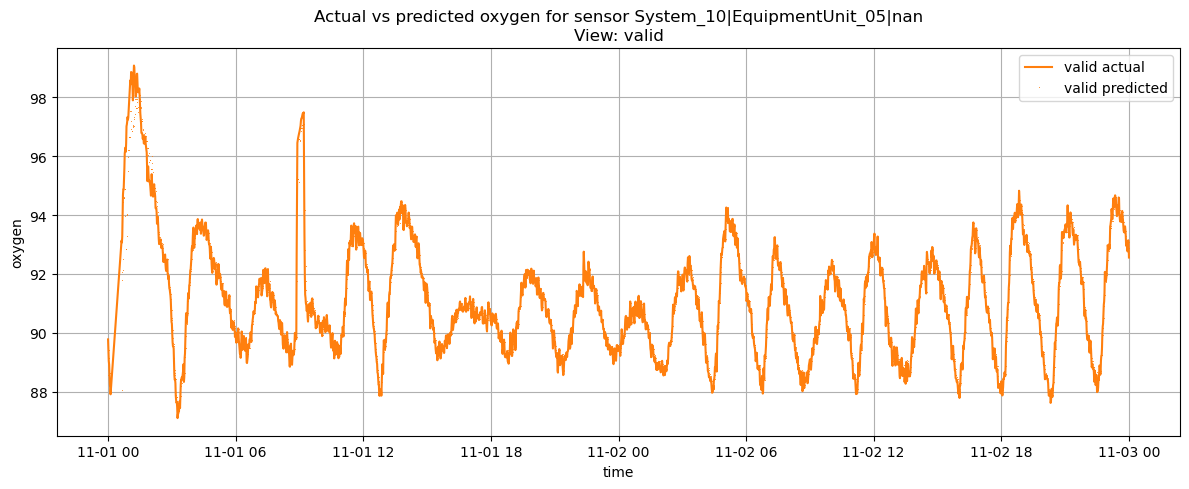

In [36]:
# %% Examples: visualising different views and zoom levels

# Choose default sensor
plot_sensor = df_model["sensor_id"].iloc[0]
# plot_sensor ='System_10|EquipmentUnit_10|SubUnit_07'

# 1) All splits together (train + valid + test)
plot_sensor_forecast(sensor_id=plot_sensor, view="all")

# 2) Only training range
plot_sensor_forecast(sensor_id=plot_sensor, view="train")

# 3) Only validation range
plot_sensor_forecast(sensor_id=plot_sensor, view="valid")

# 4) Only test range
plot_sensor_forecast(sensor_id=plot_sensor, view="test")

# 5) Zoom into the last 2 days of the validation range
plot_sensor_forecast(sensor_id=plot_sensor, view="valid", window_days=2)

# 6) Zoom into a manually specified time window
plot_sensor_forecast(sensor_id=plot_sensor, view="valid",
                     start_time="2025-11-01 00:00:00",
                     end_time="2025-11-03 00:00:00")


In [ ]:
# %% 1-week-ahead forecast for a single sensor (iterative)

target_sensor = plot_sensor
print("Target sensor for 1-week ahead forecast:", target_sensor)

sensor_hist = df_model[df_model["sensor_id"] == target_sensor].copy()
sensor_hist = sensor_hist.sort_values("time")

last_time = sensor_hist["time"].max()
print("Last observed time for sensor:", last_time)

# Number of minutes to forecast (1 week)
horizon_minutes = 7 * 24 * 60  # 10,080

# Working history (only time + value)
hist = sensor_hist[["time", value_col]].copy().reset_index(drop=True)

future_rows = []

current_time = last_time
for step in range(1, horizon_minutes + 1):
    current_time = current_time + pd.Timedelta(minutes=1)

    # Build feature row for current_time using the history (including previous forecasts)
    last_time_feat = current_time

    minute_of_day = last_time_feat.hour * 60 + last_time_feat.minute
    dayofweek = last_time_feat.dayofweek

    feat_row = {
        "minute_of_day": minute_of_day,
        "dayofweek": dayofweek,
        "sin_time": np.sin(2 * np.pi * minute_of_day / 1440),
        "cos_time": np.cos(2 * np.pi * minute_of_day / 1440),
        "sin_dow": np.sin(2 * np.pi * dayofweek / 7),
        "cos_dow": np.cos(2 * np.pi * dayofweek / 7),
    }

    # Ensure we have enough history; if not, stop
    if len(hist) < max([1, 5, 60]) + 1:
        raise RuntimeError("Not enough history to create lag features for forecasting.")

    for lag in [1, 5, 60]:
        feat_row[f"lag_{lag}"] = hist[value_col].iloc[-lag]

    # Rolling mean over last 60 minutes
    last_60 = hist[value_col].iloc[-60:] if len(hist) >= 60 else hist[value_col]
    feat_row["roll_mean_60"] = last_60.mean()

    X_future = pd.DataFrame([feat_row])[feature_cols]

    y_future = forecaster.predict(X_future)[0]

    # Store forecast
    future_rows.append({"time": current_time, "sensor_id": target_sensor, "forecast": y_future})

    # Append the forecast to history for future lags
    hist = pd.concat(
        [hist, pd.DataFrame({"time": [current_time], value_col: [y_future]})],
        ignore_index=True
    )

df_future = pd.DataFrame(future_rows)
print("Forecast shape:", df_future.shape)
df_future.head()


Target sensor for 1-week ahead forecast: System_10|EquipmentUnit_05|nan
Last observed time for sensor: 2025-11-14 09:31:00


In [ ]:
# %% Plot last 2 days of history + 1 week of forecast

history_days = 2
hist_window_start = last_time - pd.Timedelta(days=history_days)

hist_plot = sensor_hist[sensor_hist["time"] >= hist_window_start].copy()

plt.figure(figsize=(12, 5))

plt.plot(hist_plot["time"], hist_plot[value_col], label="history (last 2 days)")

# Forecast as circles
plt.plot(
    df_future["time"],
    df_future["forecast"],
    linestyle="None",
    marker="o",
    markersize=3,
    label="forecast (next 7 days)"
)

plt.xlabel("time")
plt.ylabel(value_col)
plt.title(f"1-week ahead forecast for sensor {target_sensor}")
plt.legend()
plt.tight_layout()
plt.show()

### Why does the 1-week forecast sometimes look like a straight line?

In the 1-week-ahead plot above, the forecast trace for the next 7 days can look
**almost like a straight line**. This happens because of how the model and the
multi-step forecasting loop interact:
 
1. **The model is essentially learning a smooth baseline.**  
   The main features going into the model are:
   - Recent lagged oxygen values (1, 5, 60 minutes),
   - A 60-minute rolling mean,
   - Time-of-day and day-of-week encodings.
   
   If the training data for this sensor does not have a strong long-term trend,
   the safest prediction (in terms of error) is usually **"stay close to the recent
   average"** rather than generating a strong upward or downward trend.

2. **In the multi-step loop, predictions are fed back as inputs.**  
   For each future minute, we:
   - Take the **last few predicted values** as lags,
   - Compute a new rolling mean from those predicted values,
   - Combine them with the cyclical time features,
   - Ask the model to predict the next value.
   
   If the model tends to pull predictions towards a stable baseline (e.g., around
   the typical oxygen level for that time-of-day), then once the forecast gets
   close to that baseline, **each next prediction becomes very similar to the
   previous one**.

3. **Small variations are often visually compressed.**  
   Even if there are tiny ups and downs from the cyclical time features, these
   variations may be small relative to the overall y-axis scale, so on a 7-day
   horizon they look like a **flat line**.

In short, the straight-line forecast is the model saying:

> "Given what I've seen, the safest guess for the next week is that oxygen will
> stay close to this level, without a strong trend up or down."

This behaviour is quite common for tree-based and mean-reverting forecasters when
there is no strong trend or pattern in the data to extrapolate into the future.


## Summary & Next Steps

In this notebook we:

- Loaded the **scored, processed dataset** from the anomaly detection pipeline.
- Removed:
  - Rows with null timestamps or null oxygen values.
  - The top ~1% most anomalous minutes (based on the `severity` score),
    to avoid contaminating the forecaster with extreme events or sensor faults.
- Built a **global, tag-agnostic forecaster** using:
  - Lagged oxygen values (1, 5, 60 minutes),
  - A rolling 60-minute mean,
  - Cyclical time-of-day and day-of-week features.
- Defined explicit **train/validation/test** windows as parameters:
  - Trained the model **only on the training set**.
  - Used the **validation set only** for hyperparameter tuning / model selection.
  - Evaluated the final chosen model **once on the test set** for an unbiased estimate.
- Added a flexible plotting utility (`plot_sensor_forecast`) that lets you:
  - Visualise all splits together, or only train / validation / test ranges.
  - Zoom into custom time windows via `start_time` / `end_time` or `window_days`.
- Created a **single plot** showing actual vs predicted values for one sensor across
  train, validation, and test ranges on the same timeline, with clearly different
  colours and line styles.
- Illustrated a **1-week-ahead forecast** for a single sensor and explained why
  the resulting forecast often appears as a straight line.

This design aligns with the assignment requirements by:

- Using a **single, generic model** (no reliance on specific tag values).
- Explicitly **handling anomalies** via the anomaly severity score.
- Supporting **minute-level forecasting** over multi-day horizons.
- Following best practices for **train/validation/test separation**, avoiding
  data leakage, and enabling detailed inspection of forecast quality.
